# Compile Results for IGARSS 2026

In [23]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scripts.io import read_image, KEY_INPUT_EO, KEY_INPUT_SAR, KEY_OUTPUT_SAR
from scripts.utils import c2ap, T, invT
from skimage import exposure

In [2]:
def standardize_image(image):
    """Standardize image to zero mean and unit variance."""
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    return standardized_image

In [3]:
baseline_directory = '../methods/'
METHOD_LIST = ['gbf', 'gnlm', 'tbog']

### Changi Data

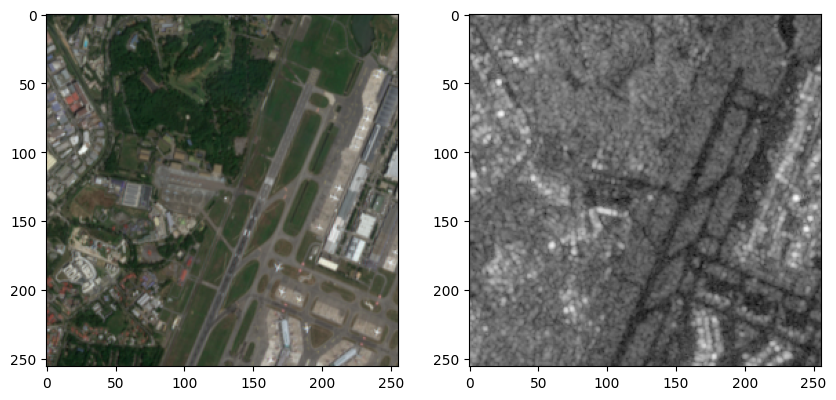

In [46]:
input_path = "../../dataset/data_changi.npz"

sar = read_image(input_path, key=KEY_INPUT_SAR).squeeze()
eo = read_image(input_path, key=KEY_INPUT_EO)
eo = exposure.adjust_gamma(eo, gamma=0.6, gain=1.0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

# plt.imsave(input_path.replace('data_', 'eo_').replace('.npz', '.png'), eo) 
# plt.imsave(input_path.replace('data_', 'sar_').replace('.npz', '.png'), sar, cmap='gray') 

### Village Data

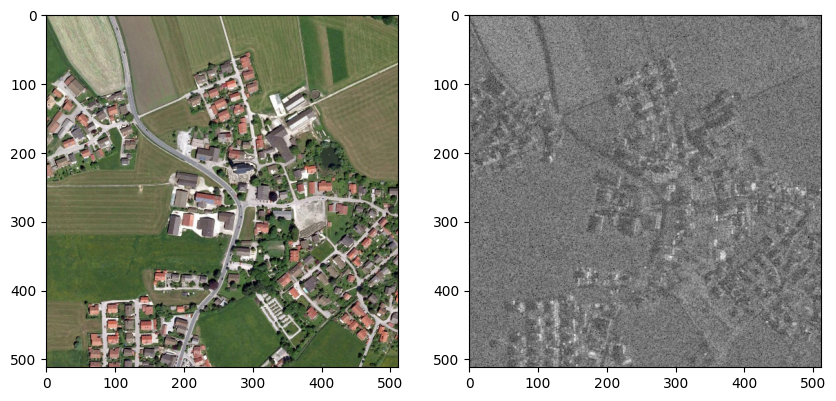

In [4]:
input_path = "../../dataset/data_village.npz"

sar = read_image(input_path, key=KEY_INPUT_SAR).squeeze()
eo = read_image(input_path, key=KEY_INPUT_EO)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo)
plt.subplot(1, 2, 2)
plt.imshow(T(sar), cmap='gray')

In [64]:
def add_annotation(img):
    font = cv2.FONT_HERSHEY_DUPLEX
    lw = 2

    img_annotated = img.copy()

    cv2.putText(img_annotated, "Tree", (45 - 20, 480 - 20 - 5), font, 0.5, (255, 0, 0), lw-1, cv2.LINE_AA)
    cv2.circle(img_annotated, (45, 480), 20, (255, 0, 0), lw)  # Tree

    cv2.putText(img_annotated, "Lake", (415 - 30, 210 - 30 - 5), font, 0.5, (255, 0, 0), lw-1, cv2.LINE_AA)
    cv2.circle(img_annotated, (415, 210), 30, (255, 0, 0), lw)  # Lake

    cv2.putText(img_annotated, "Road", (2, 230 - 5), font, 0.5, (255, 0, 0), lw-1, cv2.LINE_AA)
    cv2.rectangle(img_annotated, (2, 230), (200, 270), (255, 0, 0), lw)  # Road
    
    cv2.putText(img_annotated, "Car park", (300, 400 - 5), font, 0.5, (255, 0, 0), lw-1, cv2.LINE_AA)
    cv2.rectangle(img_annotated, (300, 400), (375, 475), (255, 0, 0), lw)  # Car park

    return img_annotated

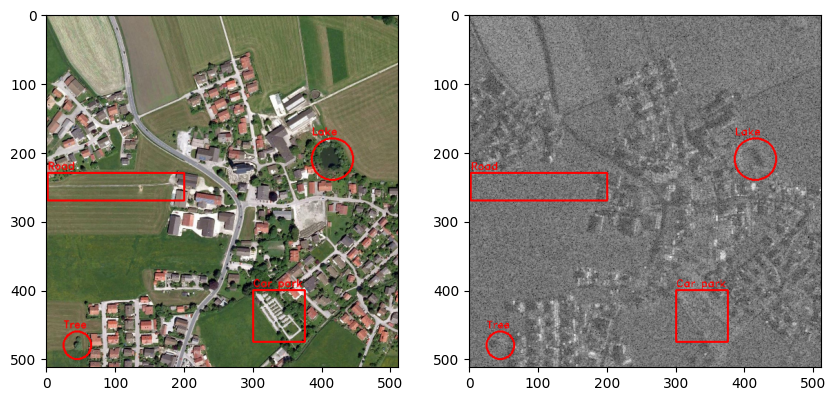

In [ ]:
eo_annotated = add_annotation(eo).clip(0, 255).astype(np.uint8)
sar_annotated = add_annotation(np.dstack([T(sar) * 255.] * 3)).clip(0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(eo_annotated)
plt.subplot(1, 2, 2)
plt.imshow(sar_annotated)

plt.imsave(Path.home() / 'Downloads' / 'eo_village_annotated.png', eo_annotated, dpi=300) 
plt.imsave(Path.home() / 'Downloads' / 'sar_village_annotated.png', sar_annotated, dpi=300) 

In [5]:
results_dict = {}

for m in METHOD_LIST:
    filenames = os.listdir(os.path.join(baseline_directory, m, 'results'))
    for f in filenames:
        if f.endswith('.mat') and 'village' in f:
            result_path = os.path.join(baseline_directory, m, 'results', f)

    filtered_data = read_image(result_path, key=KEY_OUTPUT_SAR)
    filtered_data, _ = c2ap(filtered_data)

    results_dict[m] = filtered_data

results_dict.keys()

dict_keys(['gbf', 'gnlm', 'tbog'])

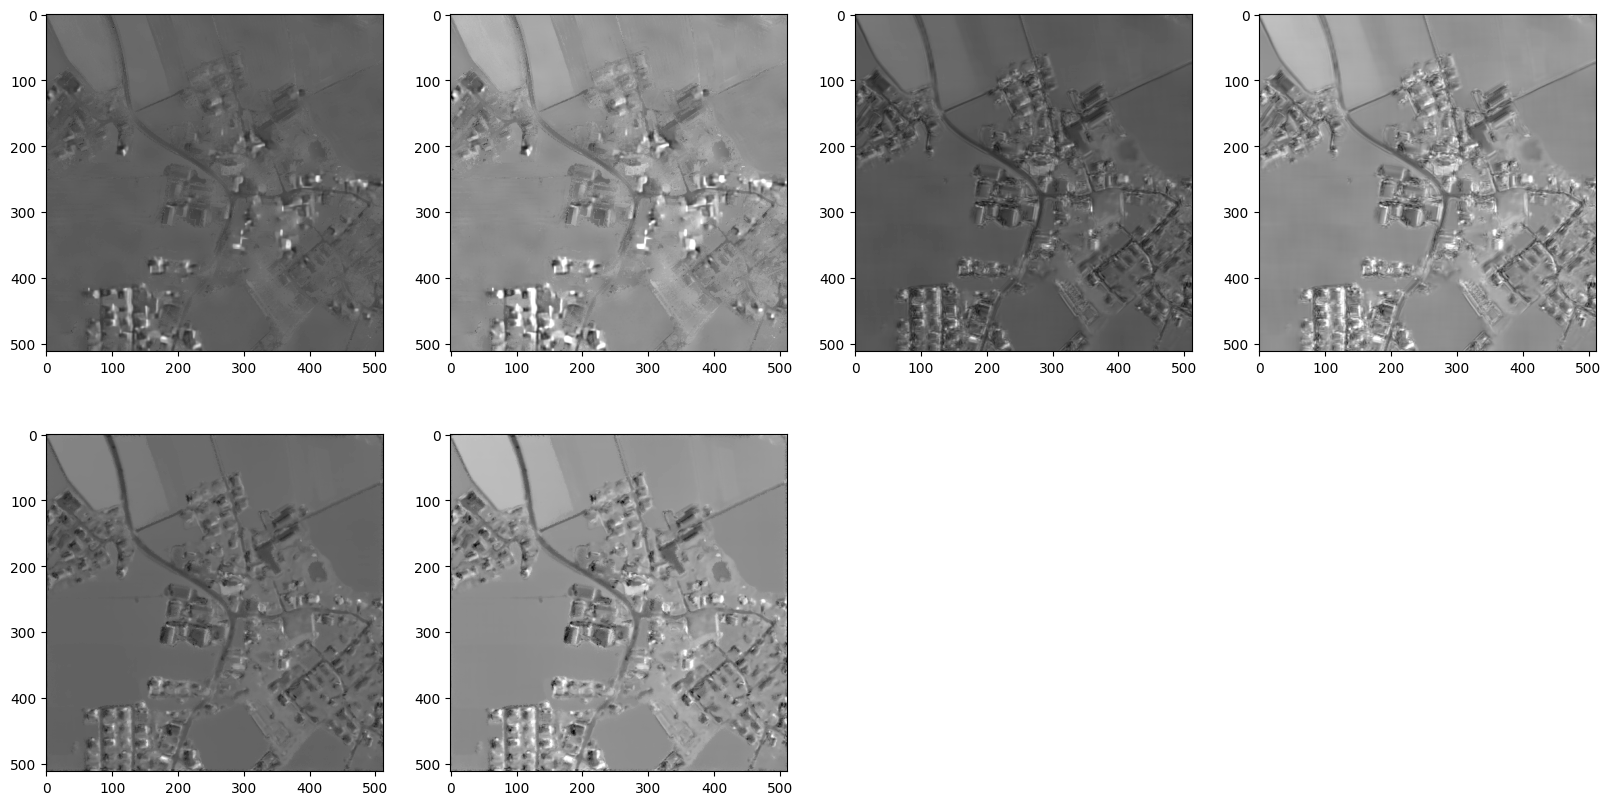

In [16]:
output_gbf = results_dict['gbf']
output_gnlm = results_dict['gnlm']
output_tbog = results_dict['tbog']

output_gbf_standardized = standardize_image(np.clip(output_gbf, 0, 255))
output_gnlm_standardized = standardize_image(np.clip(output_gnlm, 0, 255))
output_tbog_standardized = standardize_image(np.clip(output_tbog, 0, 255))

output_gbf_standardized = exposure.rescale_intensity(output_gbf_standardized, in_range=(-5, 5), out_range=(0, 1))
output_gnlm_standardized = exposure.rescale_intensity(output_gnlm_standardized, in_range=(-5, 5), out_range=(0, 1))
output_tbog_standardized = exposure.rescale_intensity(output_tbog_standardized, in_range=(-5, 5), out_range=(0, 1))

output_gbf_standardized = exposure.adjust_gamma(output_gbf_standardized, gamma=0.8, gain=1.0).squeeze()
output_gnlm_standardized = exposure.adjust_gamma(output_gnlm_standardized, gamma=0.8, gain=1.0).squeeze()
output_tbog_standardized = exposure.adjust_gamma(output_tbog_standardized, gamma=0.8, gain=1.0).squeeze()

plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.imshow(output_gbf, cmap='gray')
plt.subplot(2, 4, 2)
plt.imshow(output_gbf_standardized, cmap='gray')
plt.subplot(2, 4, 3)
plt.imshow(output_gnlm, cmap='gray')
plt.subplot(2, 4, 4)
plt.imshow(output_gnlm_standardized, cmap='gray')
plt.subplot(2, 4, 5)
plt.imshow(output_tbog, cmap='gray')
plt.subplot(2, 4, 6)
plt.imshow(output_tbog_standardized, cmap='gray')

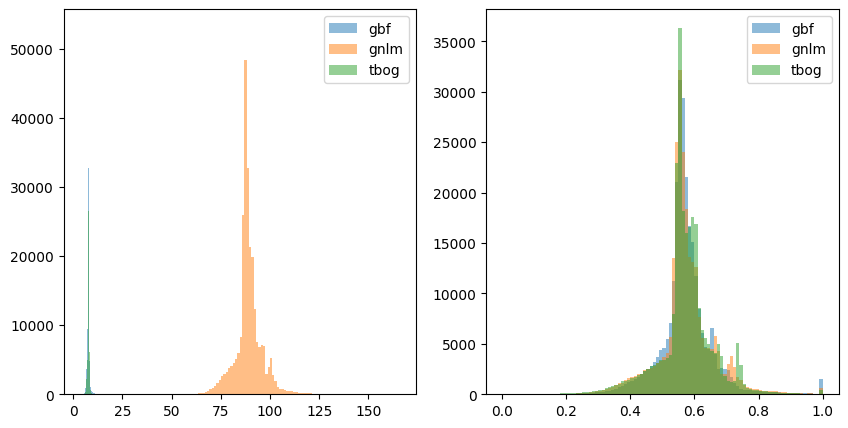

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(output_gbf.flatten(), bins=100, alpha=0.5, label='gbf');
plt.hist(output_gnlm.flatten(), bins=100, alpha=0.5, label='gnlm');
plt.hist(output_tbog.flatten(), bins=100, alpha=0.5, label='tbog');
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(output_gbf_standardized.flatten(), bins=100, alpha=0.5, label='gbf');
plt.hist(output_gnlm_standardized.flatten(), bins=100, alpha=0.5, label='gnlm');
plt.hist(output_tbog_standardized.flatten(), bins=100, alpha=0.5, label='tbog');
plt.legend()

In [8]:
plt.imsave('/home/nus/Downloads/output_village_gbf.png', output_gbf_standardized.squeeze(), cmap='gray', dpi=300)
plt.imsave('/home/nus/Downloads/output_village_gnlm.png', output_gnlm_standardized.squeeze(), cmap='gray', dpi=300)
plt.imsave('/home/nus/Downloads/output_village_tbog.png', output_tbog_standardized.squeeze(), cmap='gray', dpi=300)

### Compute ENL (Quality Assessment Metric)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


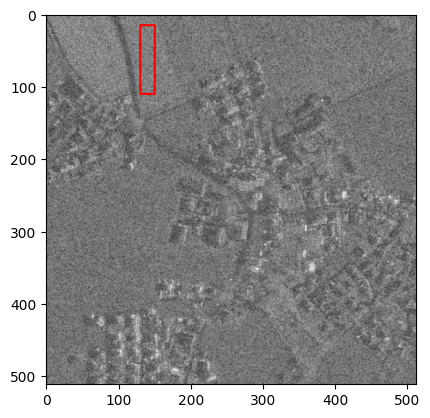

In [47]:
img = np.dstack([T(sar), T(sar), T(sar)]).copy()

xmin, xmax = 130, 150
ymin, ymax = 15, 110
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
plt.imshow(img, cmap='gray')

In [48]:
window_size = 7
enl_raw = sar[ymin:ymax, xmin:xmax].mean() ** 2 / sar[ymin:ymax, xmin:xmax].var()
enl_gbf = output_gbf_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_gbf_standardized[ymin:ymax, xmin:xmax].var()
enl_gnlm = output_gnlm_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_gnlm_standardized[ymin:ymax, xmin:xmax].var()
enl_tbog = output_tbog_standardized[ymin:ymax, xmin:xmax].mean() ** 2 / output_tbog_standardized[ymin:ymax, xmin:xmax].var()

print(f"ENL Raw: {enl_raw.mean():.2f}")
print(f"ENL GBF: {enl_gbf.mean():.2f}")
print(f"ENL GNLM: {enl_gnlm.mean():.2f}")
print(f"ENL TBOG: {enl_tbog.mean():.2f}")

ENL Raw: 3.77
ENL GBF: 9309.67
ENL GNLM: 19028.75
ENL TBOG: 44694.76


In [59]:
output_gbf_standardized_test = output_gbf_standardized.copy()
output_gbf_standardized_test = invT(output_gbf_standardized_test)
output_gbf_standardized_test = (output_gbf_standardized_test - output_gbf_standardized_test.mean()) / output_gbf_standardized_test.std() 
output_gbf_standardized_test = (output_gbf_standardized_test * sar.std()) + sar.mean() 

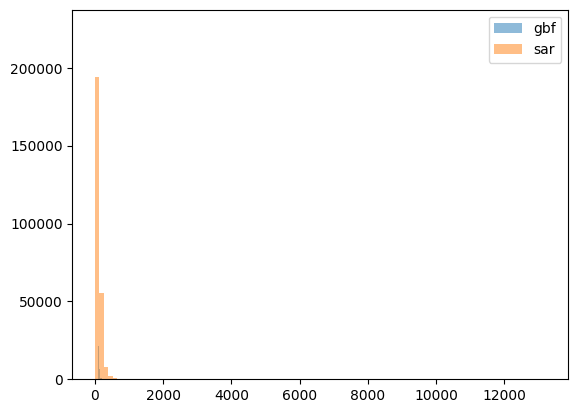

In [61]:
plt.hist(output_gbf_standardized_test.flatten(), bins=100, alpha=0.5, label='gbf');
plt.hist(sar.flatten(), bins=100, alpha=0.5, label='sar');
plt.legend();